# CIFAR10 and ResNet56

Paper: https://arxiv.org/abs/1708.07120 

Setting from this repo: https://github.com/sgugger/Deep-Learning/blob/master/Cyclical%20LR%20and%20momentums.ipynb


library requirements:

torch==1.3.1   
torchvision==0.4.2   
tqdm==4.43.0  
numpy==1.17.4   
scipy==0.19.1  
matplotlib==3.2.0  

In [1]:
import sys
sys.path.append('..')
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
%load_ext autoreload
%autoreload 2

# import

In [3]:
import os
import time
import argparse

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import get_data
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
seed = 1
inner_his = []

In [4]:
args = argparse.Namespace()
args.batch_size = 64
args.buffer_size = 10000
args.data_root = "../data"
args.dataset = "cifar10"
args.debug = True
args.decay_epochs = [35, 80, 120]
args.decay_rate = 0.1
args.dropout_rate = 0.0
args.load_path = "temp.pt"
args.log_dir = "./runs"
args.lr = 0.0001
args.n_classes = 10
args.n_epochs = 150

# model ResNet 56

from https://github.com/sgugger/Deep-Learning/blob/master/Cyclical%20LR%20and%20momentums.ipynb

In [5]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or ch_in != ch_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(ch_out)
            )

    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(x)
        out = self.bn2(self.conv2(F.relu(self.bn1(out))))
        out += shortcut
        return F.relu(out)

    
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_group_layer(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_group_layer(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(32, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def make_group_layer(self,ch_in, ch_out, num_blocks, stride):
        layers = [BasicBlock(ch_in, ch_out, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(ch_out, ch_out, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out), dim=1)

# train and test functions

In [29]:
def train(epoch):
    net.train()
    net.training = True
    train_loss = 0
    correct = 0
    total = 0

    print('\n=> Training Epoch #%d' % epoch)
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # GPU settings
        optimizer.zero_grad()
        outputs = net(inputs)               # Forward Propagation
        loss = criterion(outputs, targets)  # Loss
        loss.backward()  # Backward Propagation
        optimizer.step()  # Optimizer update

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if args.sch == 'clr': 
            scheduler.step()
            lr_list.append(scheduler.get_last_lr())
            
        if batch_idx % 100 == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                        % (epoch, num_epochs, batch_idx + 1,
                            (len(train_loader.dataset) // batch_size) + 1, loss.item(), 100. * correct / total))


def test(epoch):
    global best_acc
    net.eval()
    net.training = False
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        # Save checkpoint when best model
        acc = 100. * correct / total
        print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" % (epoch, loss.item(), acc))
    return acc, test_loss


In [7]:
def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

# load data

In [8]:
args.batch_size = 512
train_loader, test_loader = get_data(args)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.device = device

Files already downloaded and verified
Files already downloaded and verified


# code

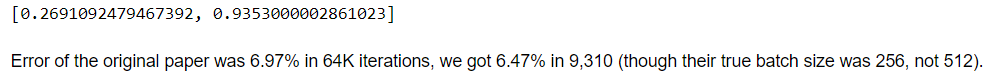

Setting, $9,310 \approx 10000 * 512 / 50000 \approx 100$ epochs

First try to train model 100 epochs with the constant learning rate 0.1 and lr decay at 60, 80. 90

## constant learning rate


[Phase 3] : Training model
| Training Epochs = 100
| Initial Learning Rate = 0.1
| Optimizer = SGD

=> Training Epoch #0
| Epoch [  0/100] Iter[  1/ 98]		Loss: 2.9698 Acc@1: 8.594%

| Validation Epoch #0			Loss: 1.7785 Acc@1: 33.28%
| Elapsed time : 0:00:32

=> Training Epoch #1
| Epoch [  1/100] Iter[  1/ 98]		Loss: 1.8296 Acc@1: 33.984%

| Validation Epoch #1			Loss: 1.6413 Acc@1: 39.82%
| Elapsed time : 0:01:04

=> Training Epoch #2
| Epoch [  2/100] Iter[  1/ 98]		Loss: 1.6088 Acc@1: 39.062%

| Validation Epoch #2			Loss: 1.5605 Acc@1: 44.77%
| Elapsed time : 0:01:34

=> Training Epoch #3
| Epoch [  3/100] Iter[  1/ 98]		Loss: 1.5219 Acc@1: 43.945%

| Validation Epoch #3			Loss: 1.3526 Acc@1: 53.29%
| Elapsed time : 0:02:06

=> Training Epoch #4
| Epoch [  4/100] Iter[  1/ 98]		Loss: 1.2856 Acc@1: 57.812%

| Validation Epoch #4			Loss: 1.5029 Acc@1: 54.78%
| Elapsed time : 0:02:39

=> Training Epoch #5
| Epoch [  5/100] Iter[  1/ 98]		Loss: 1.1523 Acc@1: 58.008%

| Validation Epoc

| Epoch [ 50/100] Iter[  1/ 98]		Loss: 0.1586 Acc@1: 95.117%

| Validation Epoch #50			Loss: 0.2553 Acc@1: 86.61%
| Elapsed time : 0:26:54

=> Training Epoch #51
| Epoch [ 51/100] Iter[  1/ 98]		Loss: 0.1243 Acc@1: 93.945%

| Validation Epoch #51			Loss: 0.3515 Acc@1: 86.45%
| Elapsed time : 0:27:24

=> Training Epoch #52
| Epoch [ 52/100] Iter[  1/ 98]		Loss: 0.1327 Acc@1: 95.312%

| Validation Epoch #52			Loss: 0.2938 Acc@1: 86.87%
| Elapsed time : 0:27:54

=> Training Epoch #53
| Epoch [ 53/100] Iter[  1/ 98]		Loss: 0.1694 Acc@1: 93.164%

| Validation Epoch #53			Loss: 0.2379 Acc@1: 88.52%
| Elapsed time : 0:28:24

=> Training Epoch #54
| Epoch [ 54/100] Iter[  1/ 98]		Loss: 0.1588 Acc@1: 94.141%

| Validation Epoch #54			Loss: 0.3570 Acc@1: 87.87%
| Elapsed time : 0:28:55

=> Training Epoch #55
| Epoch [ 55/100] Iter[  1/ 98]		Loss: 0.1200 Acc@1: 95.117%

| Validation Epoch #55			Loss: 0.3804 Acc@1: 88.09%
| Elapsed time : 0:29:28

=> Training Epoch #56
| Epoch [ 56/100] Iter[  1/ 

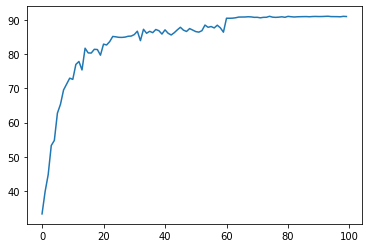

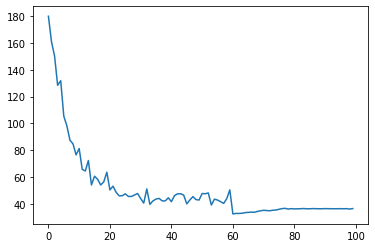

In [9]:
net = ResNet([9,8,8])
net = net.to(device)
batch_size = args.batch_size
args.epochs = 100
args.lr = 0.1
args.sch = 'constant'
args.blr = args.elr = 0.0001
optimizer = torch.optim.SGD(net.parameters(), args.lr, momentum=0.9, weight_decay=1e-4)

if args.sch == 'constant':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80, 90], gamma=0.1)
else:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=len(train_loader), epochs=args.epochs,
                                                    anneal_strategy='linear', div_factor=int(args.lr / args.blr),
                                                    final_div_factor=int(args.lr / args.elr))
num_epochs = args.epochs

criterion = nn.CrossEntropyLoss()
print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(args.lr))
print('| Optimizer = ' + optimizer.__class__.__name__)


elapsed_time = 0
new_lr = args.lr
constant_acc_list = []
constant_loss_list = []
for epoch in range(num_epochs):
    start_time = time.time()
    train(epoch)
    if args.sch == 'constant': scheduler.step()
    acc, loss = test(epoch)
    constant_acc_list.append(acc)
    constant_loss_list.append(loss)
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' % get_hms(elapsed_time))

print('\n[Phase 4] : Testing model')

plt.plot(np.arange(num_epochs), constant_acc_list, label='Accuracy')
plt.show()
plt.close()
plt.plot(np.arange(num_epochs), constant_loss_list, label='Loss')
plt.show()
plt.close()

Files already downloaded and verified
Files already downloaded and verified

[Phase 3] : Training model
| Training Epochs = 100
| Initial Learning Rate = 0.1
| Optimizer = SGD

=> Training Epoch #0
| Epoch [  0/100] Iter[  1/782]		Loss: 2.9729 Acc@1: 6.250%
| Epoch [  0/100] Iter[101/782]		Loss: 2.0886 Acc@1: 12.655%
| Epoch [  0/100] Iter[201/782]		Loss: 2.2219 Acc@1: 16.535%
| Epoch [  0/100] Iter[301/782]		Loss: 1.9219 Acc@1: 19.482%
| Epoch [  0/100] Iter[401/782]		Loss: 1.8422 Acc@1: 21.879%
| Epoch [  0/100] Iter[501/782]		Loss: 1.7411 Acc@1: 23.990%
| Epoch [  0/100] Iter[601/782]		Loss: 1.6796 Acc@1: 25.572%
| Epoch [  0/100] Iter[701/782]		Loss: 1.6267 Acc@1: 26.875%

| Validation Epoch #0			Loss: 1.6738 Acc@1: 38.72%
| Elapsed time : 0:00:49

=> Training Epoch #1
| Epoch [  1/100] Iter[  1/782]		Loss: 1.5771 Acc@1: 48.438%
| Epoch [  1/100] Iter[101/782]		Loss: 1.4221 Acc@1: 40.037%
| Epoch [  1/100] Iter[201/782]		Loss: 1.5546 Acc@1: 40.058%
| Epoch [  1/100] Iter[301/782]		

| Epoch [ 13/100] Iter[601/782]		Loss: 0.4130 Acc@1: 84.172%
| Epoch [ 13/100] Iter[701/782]		Loss: 0.4930 Acc@1: 84.199%

| Validation Epoch #13			Loss: 0.4216 Acc@1: 77.40%
| Elapsed time : 0:11:58

=> Training Epoch #14
| Epoch [ 14/100] Iter[  1/782]		Loss: 0.3437 Acc@1: 90.625%
| Epoch [ 14/100] Iter[101/782]		Loss: 0.3572 Acc@1: 84.700%
| Epoch [ 14/100] Iter[201/782]		Loss: 0.3039 Acc@1: 84.453%
| Epoch [ 14/100] Iter[301/782]		Loss: 0.6416 Acc@1: 84.417%
| Epoch [ 14/100] Iter[401/782]		Loss: 0.4175 Acc@1: 84.496%
| Epoch [ 14/100] Iter[501/782]		Loss: 0.4270 Acc@1: 84.512%
| Epoch [ 14/100] Iter[601/782]		Loss: 0.4506 Acc@1: 84.430%
| Epoch [ 14/100] Iter[701/782]		Loss: 0.4693 Acc@1: 84.433%

| Validation Epoch #14			Loss: 0.4845 Acc@1: 80.59%
| Elapsed time : 0:12:48

=> Training Epoch #15
| Epoch [ 15/100] Iter[  1/782]		Loss: 0.5880 Acc@1: 81.250%
| Epoch [ 15/100] Iter[101/782]		Loss: 0.4154 Acc@1: 84.653%
| Epoch [ 15/100] Iter[201/782]		Loss: 0.2866 Acc@1: 84.942%
| Epo

| Epoch [ 27/100] Iter[601/782]		Loss: 0.6465 Acc@1: 87.952%
| Epoch [ 27/100] Iter[701/782]		Loss: 0.2385 Acc@1: 87.877%

| Validation Epoch #27			Loss: 0.4323 Acc@1: 84.54%
| Elapsed time : 0:23:40

=> Training Epoch #28
| Epoch [ 28/100] Iter[  1/782]		Loss: 0.3488 Acc@1: 87.500%
| Epoch [ 28/100] Iter[101/782]		Loss: 0.2122 Acc@1: 87.871%
| Epoch [ 28/100] Iter[201/782]		Loss: 0.3728 Acc@1: 87.998%
| Epoch [ 28/100] Iter[301/782]		Loss: 0.3742 Acc@1: 87.946%
| Epoch [ 28/100] Iter[401/782]		Loss: 0.6680 Acc@1: 88.014%
| Epoch [ 28/100] Iter[501/782]		Loss: 0.3671 Acc@1: 88.021%
| Epoch [ 28/100] Iter[601/782]		Loss: 0.2959 Acc@1: 87.828%
| Epoch [ 28/100] Iter[701/782]		Loss: 0.3582 Acc@1: 87.825%

| Validation Epoch #28			Loss: 0.4396 Acc@1: 86.24%
| Elapsed time : 0:24:35

=> Training Epoch #29
| Epoch [ 29/100] Iter[  1/782]		Loss: 0.3083 Acc@1: 90.625%
| Epoch [ 29/100] Iter[101/782]		Loss: 0.3766 Acc@1: 88.769%
| Epoch [ 29/100] Iter[201/782]		Loss: 0.4525 Acc@1: 88.293%
| Epo

| Epoch [ 41/100] Iter[601/782]		Loss: 0.2674 Acc@1: 89.299%
| Epoch [ 41/100] Iter[701/782]		Loss: 0.2588 Acc@1: 89.370%

| Validation Epoch #41			Loss: 0.4284 Acc@1: 87.31%
| Elapsed time : 0:35:30

=> Training Epoch #42
| Epoch [ 42/100] Iter[  1/782]		Loss: 0.4434 Acc@1: 90.625%
| Epoch [ 42/100] Iter[101/782]		Loss: 0.2218 Acc@1: 90.037%
| Epoch [ 42/100] Iter[201/782]		Loss: 0.3547 Acc@1: 89.342%
| Epoch [ 42/100] Iter[301/782]		Loss: 0.3222 Acc@1: 89.120%
| Epoch [ 42/100] Iter[401/782]		Loss: 0.2395 Acc@1: 89.074%
| Epoch [ 42/100] Iter[501/782]		Loss: 0.3771 Acc@1: 89.162%
| Epoch [ 42/100] Iter[601/782]		Loss: 0.1874 Acc@1: 89.185%
| Epoch [ 42/100] Iter[701/782]		Loss: 0.2801 Acc@1: 89.176%

| Validation Epoch #42			Loss: 0.3177 Acc@1: 86.78%
| Elapsed time : 0:36:22

=> Training Epoch #43
| Epoch [ 43/100] Iter[  1/782]		Loss: 0.3652 Acc@1: 87.500%
| Epoch [ 43/100] Iter[101/782]		Loss: 0.3571 Acc@1: 89.851%
| Epoch [ 43/100] Iter[201/782]		Loss: 0.1926 Acc@1: 90.151%
| Epo

| Epoch [ 55/100] Iter[601/782]		Loss: 0.2709 Acc@1: 90.071%
| Epoch [ 55/100] Iter[701/782]		Loss: 0.3150 Acc@1: 89.974%

| Validation Epoch #55			Loss: 0.3051 Acc@1: 85.56%
| Elapsed time : 0:47:12

=> Training Epoch #56
| Epoch [ 56/100] Iter[  1/782]		Loss: 0.2518 Acc@1: 90.625%
| Epoch [ 56/100] Iter[101/782]		Loss: 0.1587 Acc@1: 90.795%
| Epoch [ 56/100] Iter[201/782]		Loss: 0.2409 Acc@1: 90.508%
| Epoch [ 56/100] Iter[301/782]		Loss: 0.4592 Acc@1: 90.739%
| Epoch [ 56/100] Iter[401/782]		Loss: 0.2084 Acc@1: 90.621%
| Epoch [ 56/100] Iter[501/782]		Loss: 0.4602 Acc@1: 90.453%
| Epoch [ 56/100] Iter[601/782]		Loss: 0.2242 Acc@1: 90.287%
| Epoch [ 56/100] Iter[701/782]		Loss: 0.2962 Acc@1: 90.217%

| Validation Epoch #56			Loss: 0.3180 Acc@1: 88.30%
| Elapsed time : 0:48:13

=> Training Epoch #57
| Epoch [ 57/100] Iter[  1/782]		Loss: 0.3130 Acc@1: 85.938%
| Epoch [ 57/100] Iter[101/782]		Loss: 0.2242 Acc@1: 90.950%
| Epoch [ 57/100] Iter[201/782]		Loss: 0.4077 Acc@1: 90.835%
| Epo

| Epoch [ 69/100] Iter[601/782]		Loss: 0.1504 Acc@1: 97.546%
| Epoch [ 69/100] Iter[701/782]		Loss: 0.0855 Acc@1: 97.555%

| Validation Epoch #69			Loss: 0.2383 Acc@1: 92.96%
| Elapsed time : 0:58:45

=> Training Epoch #70
| Epoch [ 70/100] Iter[  1/782]		Loss: 0.0383 Acc@1: 98.438%
| Epoch [ 70/100] Iter[101/782]		Loss: 0.0460 Acc@1: 98.159%
| Epoch [ 70/100] Iter[201/782]		Loss: 0.0586 Acc@1: 98.049%
| Epoch [ 70/100] Iter[301/782]		Loss: 0.1113 Acc@1: 97.939%
| Epoch [ 70/100] Iter[401/782]		Loss: 0.0960 Acc@1: 97.802%
| Epoch [ 70/100] Iter[501/782]		Loss: 0.0185 Acc@1: 97.808%
| Epoch [ 70/100] Iter[601/782]		Loss: 0.0755 Acc@1: 97.808%
| Epoch [ 70/100] Iter[701/782]		Loss: 0.0805 Acc@1: 97.787%

| Validation Epoch #70			Loss: 0.3030 Acc@1: 92.98%
| Elapsed time : 0:59:35

=> Training Epoch #71
| Epoch [ 71/100] Iter[  1/782]		Loss: 0.0679 Acc@1: 96.875%
| Epoch [ 71/100] Iter[101/782]		Loss: 0.0327 Acc@1: 97.741%
| Epoch [ 71/100] Iter[201/782]		Loss: 0.1306 Acc@1: 97.963%
| Epo

| Epoch [ 83/100] Iter[601/782]		Loss: 0.0106 Acc@1: 99.059%
| Epoch [ 83/100] Iter[701/782]		Loss: 0.0160 Acc@1: 99.033%

| Validation Epoch #83			Loss: 0.2888 Acc@1: 93.43%
| Elapsed time : 1:10:05

=> Training Epoch #84
| Epoch [ 84/100] Iter[  1/782]		Loss: 0.0151 Acc@1: 100.000%
| Epoch [ 84/100] Iter[101/782]		Loss: 0.0158 Acc@1: 99.257%
| Epoch [ 84/100] Iter[201/782]		Loss: 0.0182 Acc@1: 99.223%
| Epoch [ 84/100] Iter[301/782]		Loss: 0.0143 Acc@1: 99.232%
| Epoch [ 84/100] Iter[401/782]		Loss: 0.0114 Acc@1: 99.186%
| Epoch [ 84/100] Iter[501/782]		Loss: 0.0174 Acc@1: 99.180%
| Epoch [ 84/100] Iter[601/782]		Loss: 0.0339 Acc@1: 99.150%
| Epoch [ 84/100] Iter[701/782]		Loss: 0.0247 Acc@1: 99.155%

| Validation Epoch #84			Loss: 0.3100 Acc@1: 93.45%
| Elapsed time : 1:10:53

=> Training Epoch #85
| Epoch [ 85/100] Iter[  1/782]		Loss: 0.0486 Acc@1: 96.875%
| Epoch [ 85/100] Iter[101/782]		Loss: 0.0623 Acc@1: 98.994%
| Epoch [ 85/100] Iter[201/782]		Loss: 0.0378 Acc@1: 99.106%
| Ep

| Epoch [ 97/100] Iter[601/782]		Loss: 0.0069 Acc@1: 99.254%
| Epoch [ 97/100] Iter[701/782]		Loss: 0.0279 Acc@1: 99.227%

| Validation Epoch #97			Loss: 0.2970 Acc@1: 93.68%
| Elapsed time : 1:22:22

=> Training Epoch #98
| Epoch [ 98/100] Iter[  1/782]		Loss: 0.0098 Acc@1: 100.000%
| Epoch [ 98/100] Iter[101/782]		Loss: 0.0227 Acc@1: 99.474%
| Epoch [ 98/100] Iter[201/782]		Loss: 0.0458 Acc@1: 99.386%
| Epoch [ 98/100] Iter[301/782]		Loss: 0.0293 Acc@1: 99.330%
| Epoch [ 98/100] Iter[401/782]		Loss: 0.0091 Acc@1: 99.287%
| Epoch [ 98/100] Iter[501/782]		Loss: 0.0085 Acc@1: 99.292%
| Epoch [ 98/100] Iter[601/782]		Loss: 0.0381 Acc@1: 99.264%
| Epoch [ 98/100] Iter[701/782]		Loss: 0.0546 Acc@1: 99.264%

| Validation Epoch #98			Loss: 0.3039 Acc@1: 93.55%
| Elapsed time : 1:23:10

=> Training Epoch #99
| Epoch [ 99/100] Iter[  1/782]		Loss: 0.0555 Acc@1: 96.875%
| Epoch [ 99/100] Iter[101/782]		Loss: 0.0131 Acc@1: 99.242%
| Epoch [ 99/100] Iter[201/782]		Loss: 0.0045 Acc@1: 99.316%
| Ep

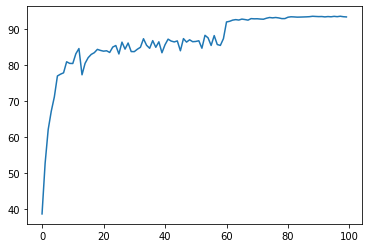

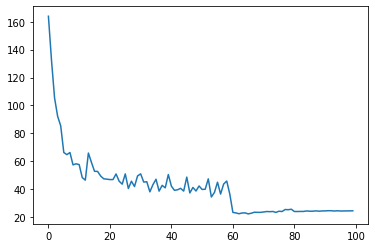

In [10]:
args.batch_size = 64
train_loader, test_loader = get_data(args)
net = ResNet([9,8,8])
net = net.to(device)
batch_size = args.batch_size
args.epochs = 100
args.lr = 0.1
args.sch = 'constant'
args.blr = args.elr = 0.0001
optimizer = torch.optim.SGD(net.parameters(), args.lr, momentum=0.9, weight_decay=1e-4)

if args.sch == 'constant':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80, 90], gamma=0.1)
else:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=len(train_loader), epochs=args.epochs,
                                                    anneal_strategy='linear', div_factor=int(args.lr / args.blr),
                                                    final_div_factor=int(args.lr / args.elr))
num_epochs = args.epochs

criterion = nn.CrossEntropyLoss()
print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(args.lr))
print('| Optimizer = ' + optimizer.__class__.__name__)


elapsed_time = 0
new_lr = args.lr
constant64_acc_list = []
constant64_loss_list = []
for epoch in range(num_epochs):
    start_time = time.time()
    train(epoch)
    if args.sch == 'constant': scheduler.step()
    acc, loss = test(epoch)
    constant64_acc_list.append(acc)
    constant64_loss_list.append(loss)
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' % get_hms(elapsed_time))

print('\n[Phase 4] : Testing model')

plt.plot(np.arange(num_epochs), constant64_acc_list, label='Accuracy')
plt.show()
plt.close()
plt.plot(np.arange(num_epochs), constant64_loss_list, label='Loss')
plt.show()
plt.close()

Conclusion:

The baseline is incorrect. 

9000 iterations\90 epochs will achieve 93.5% with a constant and decay learning rate scheduler and batch size 64!

## OneCycleLR

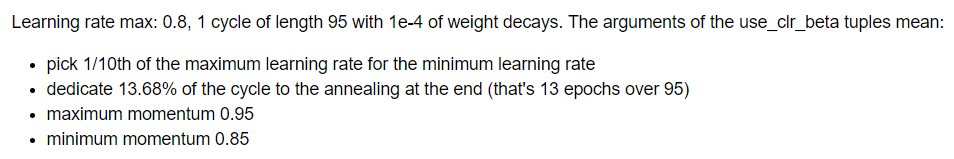

maximum lr 0.8, minimum lr 0.08 as the begin/base learning rate, final learning rate  use a very small value

Try to use 20 epochs(20% of 100 epochs, not 100 epochs in the repo) OneCycleLR

Files already downloaded and verified
Files already downloaded and verified

[Phase 3] : Training model
| Training Epochs = 20
| Initial Learning Rate = 0.8
| Optimizer = SGD

=> Training Epoch #0
| Epoch [  0/ 20] Iter[  1/ 98]		Loss: 2.6764 Acc@1: 9.766%

| Validation Epoch #0			Loss: 1.8530 Acc@1: 32.38%
| Elapsed time : 0:00:30

=> Training Epoch #1
| Epoch [  1/ 20] Iter[  1/ 98]		Loss: 1.5835 Acc@1: 40.820%

| Validation Epoch #1			Loss: 1.5302 Acc@1: 45.71%
| Elapsed time : 0:01:01

=> Training Epoch #2
| Epoch [  2/ 20] Iter[  1/ 98]		Loss: 1.5434 Acc@1: 43.750%

| Validation Epoch #2			Loss: 1.6363 Acc@1: 47.07%
| Elapsed time : 0:01:31

=> Training Epoch #3
| Epoch [  3/ 20] Iter[  1/ 98]		Loss: 1.2572 Acc@1: 54.883%

| Validation Epoch #3			Loss: 1.4343 Acc@1: 51.83%
| Elapsed time : 0:02:01

=> Training Epoch #4
| Epoch [  4/ 20] Iter[  1/ 98]		Loss: 0.9864 Acc@1: 65.234%

| Validation Epoch #4			Loss: 1.1849 Acc@1: 63.64%
| Elapsed time : 0:02:32

=> Training Epoch #5
| Ep

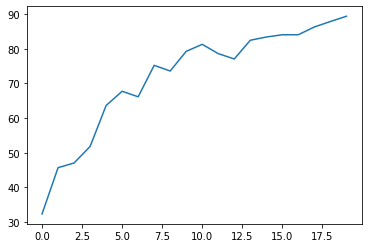

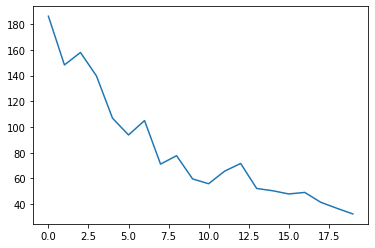

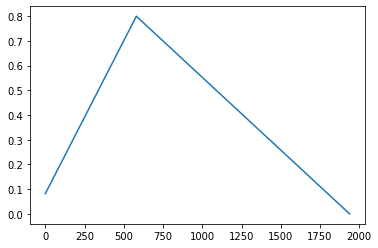

In [19]:
args.batch_size = 512
train_loader, test_loader = get_data(args)
net = ResNet([9,8,8])
net = net.to(device)
batch_size = args.batch_size
args.epochs = 20
args.lr = 0.8
args.sch = 'clr'
args.blr = 0.08
args.elr = 0.0001

optimizer = torch.optim.SGD(net.parameters(), 0.1, momentum=0.9, weight_decay=1e-4)

if args.sch == 'constant':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80, 90], gamma=0.1)
else:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=len(train_loader), epochs=args.epochs,
                                                    anneal_strategy='linear', div_factor=int(args.lr / args.blr),
                                                    final_div_factor=int(args.lr / args.elr))
num_epochs = args.epochs

criterion = nn.CrossEntropyLoss()
print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(args.lr))
print('| Optimizer = ' + optimizer.__class__.__name__)


elapsed_time = 0
new_lr = args.lr
acc_list = []
loss_list = []
lr_list = []
for epoch in range(num_epochs):
    start_time = time.time()
    train(epoch)
    if args.sch == 'constant': scheduler.step()
    acc, loss = test(epoch)
    acc_list.append(acc)
    loss_list.append(loss)
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' % get_hms(elapsed_time))

print('\n[Phase 4] : Testing model')

plt.plot(np.arange(num_epochs), acc_list, label='Accuracy')
plt.show()
plt.close()
plt.plot(np.arange(num_epochs), loss_list, label='Loss')
plt.show()
plt.close()
plt.plot(np.arange(len(lr_list)), lr_list, label='Learning rate')
plt.show()
plt.close()

Files already downloaded and verified
Files already downloaded and verified

[Phase 3] : Training model
| Training Epochs = 20
| Initial Learning Rate = 0.8
| Optimizer = SGD

=> Training Epoch #0
| Epoch [  0/ 20] Iter[  1/782]		Loss: 2.5349 Acc@1: 12.500%
| Epoch [  0/ 20] Iter[101/782]		Loss: 2.0879 Acc@1: 14.542%
| Epoch [  0/ 20] Iter[201/782]		Loss: 2.0163 Acc@1: 17.374%
| Epoch [  0/ 20] Iter[301/782]		Loss: 1.9721 Acc@1: 19.160%
| Epoch [  0/ 20] Iter[401/782]		Loss: 1.9342 Acc@1: 21.045%
| Epoch [  0/ 20] Iter[501/782]		Loss: 1.8178 Acc@1: 22.514%
| Epoch [  0/ 20] Iter[601/782]		Loss: 1.7520 Acc@1: 24.111%
| Epoch [  0/ 20] Iter[701/782]		Loss: 1.6229 Acc@1: 25.602%

| Validation Epoch #0			Loss: 1.7023 Acc@1: 36.19%
| Elapsed time : 0:00:46

=> Training Epoch #1
| Epoch [  1/ 20] Iter[  1/782]		Loss: 1.8865 Acc@1: 35.938%
| Epoch [  1/ 20] Iter[101/782]		Loss: 1.5877 Acc@1: 39.186%
| Epoch [  1/ 20] Iter[201/782]		Loss: 1.4215 Acc@1: 39.801%
| Epoch [  1/ 20] Iter[301/782]		

| Epoch [ 13/ 20] Iter[601/782]		Loss: 0.6764 Acc@1: 79.311%
| Epoch [ 13/ 20] Iter[701/782]		Loss: 0.5411 Acc@1: 79.253%

| Validation Epoch #13			Loss: 0.8375 Acc@1: 73.17%
| Elapsed time : 0:11:21

=> Training Epoch #14
| Epoch [ 14/ 20] Iter[  1/782]		Loss: 0.6040 Acc@1: 78.125%
| Epoch [ 14/ 20] Iter[101/782]		Loss: 0.5444 Acc@1: 78.883%
| Epoch [ 14/ 20] Iter[201/782]		Loss: 0.7001 Acc@1: 79.656%
| Epoch [ 14/ 20] Iter[301/782]		Loss: 0.4333 Acc@1: 79.480%
| Epoch [ 14/ 20] Iter[401/782]		Loss: 0.9610 Acc@1: 79.360%
| Epoch [ 14/ 20] Iter[501/782]		Loss: 0.7554 Acc@1: 79.616%
| Epoch [ 14/ 20] Iter[601/782]		Loss: 0.6345 Acc@1: 79.617%
| Epoch [ 14/ 20] Iter[701/782]		Loss: 0.5793 Acc@1: 79.823%

| Validation Epoch #14			Loss: 0.5642 Acc@1: 80.63%
| Elapsed time : 0:12:08

=> Training Epoch #15
| Epoch [ 15/ 20] Iter[  1/782]		Loss: 0.4185 Acc@1: 87.500%
| Epoch [ 15/ 20] Iter[101/782]		Loss: 0.6258 Acc@1: 82.101%
| Epoch [ 15/ 20] Iter[201/782]		Loss: 0.6363 Acc@1: 81.133%
| Epo

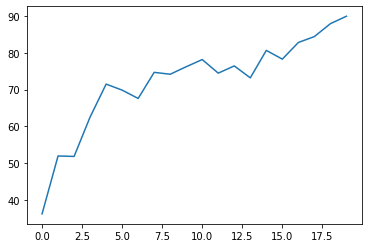

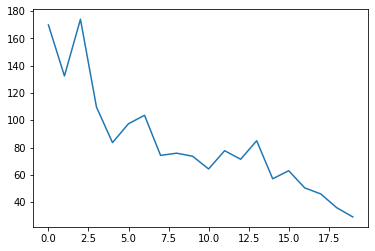

In [30]:
args.batch_size = 64
train_loader, test_loader = get_data(args)
net = ResNet([9,8,8])
net = net.to(device)
batch_size = args.batch_size
args.epochs = 20
args.lr = 0.8
args.sch = 'clr'
args.blr = 0.08
args.elr = 0.0001

optimizer = torch.optim.SGD(net.parameters(), 0.1, momentum=0.9, weight_decay=1e-4)

if args.sch == 'constant':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80, 90], gamma=0.1)
else:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=len(train_loader), epochs=args.epochs,
                                                    anneal_strategy='linear', div_factor=int(args.lr / args.blr),
                                                    final_div_factor=int(args.lr / args.elr))
num_epochs = args.epochs

criterion = nn.CrossEntropyLoss()
print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(args.lr))
print('| Optimizer = ' + optimizer.__class__.__name__)


elapsed_time = 0
new_lr = args.lr
acc64_list = []
loss64_list = []
lr_list = []
for epoch in range(num_epochs):
    start_time = time.time()
    train(epoch)
    if args.sch == 'constant': scheduler.step()
    acc, loss = test(epoch)
    acc64_list.append(acc)
    loss64_list.append(loss)
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' % get_hms(elapsed_time))

print('\n[Phase 4] : Testing model')

plt.plot(np.arange(num_epochs), acc64_list, label='Accuracy')
plt.show()
plt.close()
plt.plot(np.arange(num_epochs), loss64_list, label='Loss')
plt.show()
plt.close()

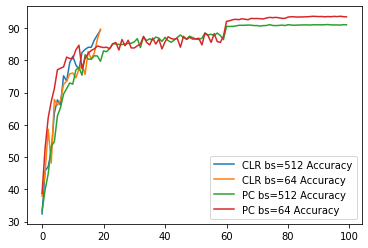

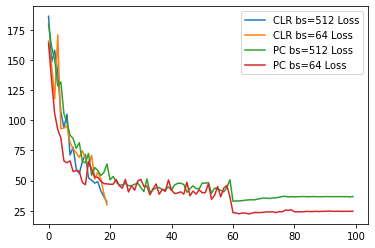

In [22]:

plt.plot(np.arange(20), acc_list, label='CLR bs=512 Accuracy')
plt.plot(np.arange(20), acc64_list, label='CLR bs=64 Accuracy')
plt.plot(np.arange(100), constant_acc_list, label='PC bs=512 Accuracy')
plt.plot(np.arange(100), constant64_acc_list, label='PC bs=64 Accuracy')
plt.legend()
plt.show()
plt.close()

plt.plot(np.arange(20), loss_list, label='CLR bs=512 Loss')
plt.plot(np.arange(20), loss64_list, label='CLR bs=64 Loss')
plt.plot(np.arange(100), constant_loss_list, label='PC bs=512 Loss')
plt.plot(np.arange(100), constant64_loss_list, label='PC bs=64 Loss')
plt.legend()
plt.show()
plt.close()


# more epochs

Files already downloaded and verified
Files already downloaded and verified

[Phase 3] : Training model
| Training Epochs = 50
| Initial Learning Rate = 0.8
| Optimizer = SGD

=> Training Epoch #0
| Epoch [  0/ 50] Iter[  1/ 98]		Loss: 2.6079 Acc@1: 8.398%

| Validation Epoch #0			Loss: 1.7316 Acc@1: 37.31%
| Elapsed time : 0:00:30

=> Training Epoch #1
| Epoch [  1/ 50] Iter[  1/ 98]		Loss: 1.6579 Acc@1: 38.086%

| Validation Epoch #1			Loss: 1.6577 Acc@1: 43.01%
| Elapsed time : 0:01:01

=> Training Epoch #2
| Epoch [  2/ 50] Iter[  1/ 98]		Loss: 1.4475 Acc@1: 46.875%

| Validation Epoch #2			Loss: 1.9617 Acc@1: 45.68%
| Elapsed time : 0:01:34

=> Training Epoch #3
| Epoch [  3/ 50] Iter[  1/ 98]		Loss: 1.2518 Acc@1: 54.688%

| Validation Epoch #3			Loss: 1.1726 Acc@1: 58.90%
| Elapsed time : 0:02:07

=> Training Epoch #4
| Epoch [  4/ 50] Iter[  1/ 98]		Loss: 1.0127 Acc@1: 62.109%

| Validation Epoch #4			Loss: 1.1715 Acc@1: 58.81%
| Elapsed time : 0:02:40

=> Training Epoch #5
| Ep

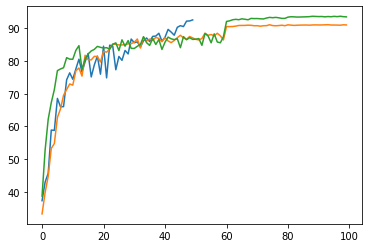

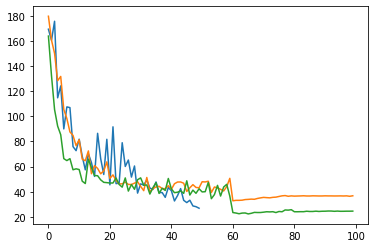

In [34]:
args.batch_size = 512
train_loader, test_loader = get_data(args)
net = ResNet([9,8,8])
net = net.to(device)
batch_size = args.batch_size
args.epochs = 50
args.lr = 0.8
args.sch = 'clr'
args.blr = 0.08
args.elr = 0.0001

optimizer = torch.optim.SGD(net.parameters(), 0.1, momentum=0.9, weight_decay=1e-4)

if args.sch == 'constant':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80, 90], gamma=0.1)
else:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=len(train_loader), epochs=args.epochs,
                                                    anneal_strategy='linear', div_factor=int(args.lr / args.blr),
                                                    final_div_factor=int(args.lr / args.elr))
num_epochs = args.epochs

criterion = nn.CrossEntropyLoss()
print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(args.lr))
print('| Optimizer = ' + optimizer.__class__.__name__)


elapsed_time = 0
new_lr = args.lr
acc50_list = []
loss50_list = []
lr_list = []
for epoch in range(num_epochs):
    start_time = time.time()
    train(epoch)
    if args.sch == 'constant': scheduler.step()
    acc, loss = test(epoch)
    acc50_list.append(acc)
    loss50_list.append(loss)
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' % get_hms(elapsed_time))

print('\n[Phase 4] : Testing model')

plt.plot(np.arange(num_epochs), acc50_list, label='CLR bs=512 Accuracy')
plt.plot(np.arange(100), constant_acc_list, label='PC bs=512 Accuracy')
plt.plot(np.arange(100), constant64_acc_list, label='PC bs=64 Accuracy')
plt.show()
plt.close()
plt.plot(np.arange(num_epochs), loss50_list, label='CLR bs=512 Loss')
plt.plot(np.arange(100), constant_loss_list, label='PC bs=512 Loss')
plt.plot(np.arange(100), constant64_loss_list, label='PC bs=64 Loss')
plt.show()
plt.close()

## OneCycleLR from LR range test

ResNet 9,9,9
A: 
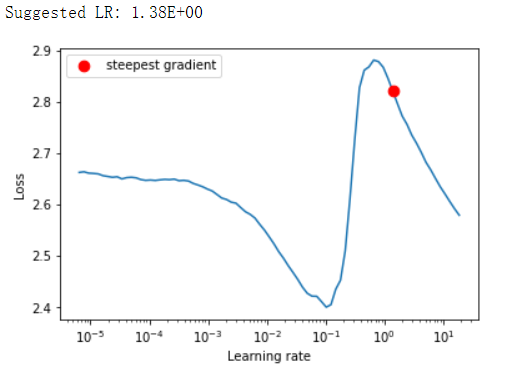

B:
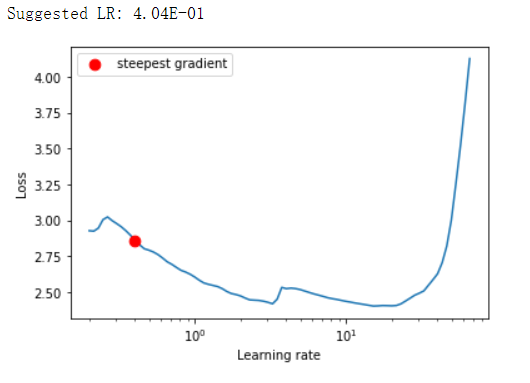

Trial

1. max lr = 0.1, min lr = 0.001
2. max lr = 2, min lr = 0.2
3. max lr = 1, min lr = 0.1

### 0.001 - 0.1

Files already downloaded and verified
Files already downloaded and verified

[Phase 3] : Training model
| Training Epochs = 20
| Initial Learning Rate = 0.1
| Optimizer = SGD

=> Training Epoch #0
| Epoch [  0/ 20] Iter[  1/ 98]		Loss: 2.6690 Acc@1: 6.055%

| Validation Epoch #0			Loss: 2.0514 Acc@1: 27.65%
| Elapsed time : 0:00:30

=> Training Epoch #1
| Epoch [  1/ 20] Iter[  1/ 98]		Loss: 1.6353 Acc@1: 35.156%

| Validation Epoch #1			Loss: 3.3160 Acc@1: 30.75%
| Elapsed time : 0:01:00

=> Training Epoch #2
| Epoch [  2/ 20] Iter[  1/ 98]		Loss: 1.3124 Acc@1: 53.906%

| Validation Epoch #2			Loss: 1.7691 Acc@1: 47.78%
| Elapsed time : 0:01:30

=> Training Epoch #3
| Epoch [  3/ 20] Iter[  1/ 98]		Loss: 1.0721 Acc@1: 64.062%

| Validation Epoch #3			Loss: 1.0789 Acc@1: 64.97%
| Elapsed time : 0:02:00

=> Training Epoch #4
| Epoch [  4/ 20] Iter[  1/ 98]		Loss: 0.8930 Acc@1: 69.141%

| Validation Epoch #4			Loss: 1.2324 Acc@1: 63.84%
| Elapsed time : 0:02:30

=> Training Epoch #5
| Ep

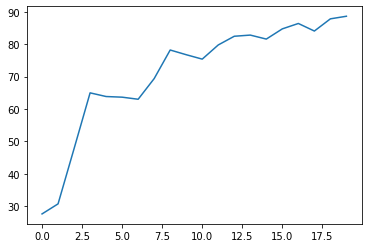

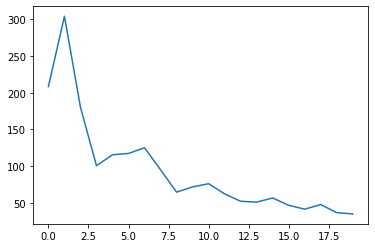

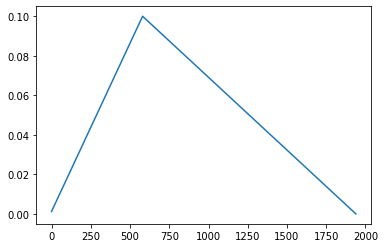

In [31]:
args.batch_size = 512
train_loader, test_loader = get_data(args)
net = ResNet([9, 9, 9])
net = net.to(device)
batch_size = args.batch_size
args.epochs = 20
args.lr = 0.1
args.sch = 'clr'
args.blr = 0.001
args.elr = 0.0001

optimizer = torch.optim.SGD(net.parameters(), 0.1, momentum=0.9, weight_decay=1e-4)

if args.sch == 'constant':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80, 90], gamma=0.1)
else:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=len(train_loader), epochs=args.epochs,
                                                    anneal_strategy='linear', div_factor=int(args.lr / args.blr),
                                                    final_div_factor=int(args.lr / args.elr))
num_epochs = args.epochs

criterion = nn.CrossEntropyLoss()
print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(args.lr))
print('| Optimizer = ' + optimizer.__class__.__name__)


elapsed_time = 0
new_lr = args.lr
acc_list = []
loss_list = []
lr_list = []
for epoch in range(num_epochs):
    start_time = time.time()
    train(epoch)
    if args.sch == 'constant': scheduler.step()
    acc, loss = test(epoch)
    acc_list.append(acc)
    loss_list.append(loss)
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' % get_hms(elapsed_time))

print('\n[Phase 4] : Testing model')

plt.plot(np.arange(num_epochs), acc_list, label='Accuracy')
plt.show()
plt.close()
plt.plot(np.arange(num_epochs), loss_list, label='Loss')
plt.show()
plt.close()

plt.plot(np.arange(len(lr_list)), lr_list, label='Learning rate')
plt.show()
plt.close()

### 0.2 - 2

Files already downloaded and verified
Files already downloaded and verified

[Phase 3] : Training model
| Training Epochs = 20
| Initial Learning Rate = 2
| Optimizer = SGD

=> Training Epoch #0
| Epoch [  0/ 20] Iter[  1/ 98]		Loss: 2.7197 Acc@1: 10.742%

| Validation Epoch #0			Loss: 2.3230 Acc@1: 10.15%
| Elapsed time : 0:00:30

=> Training Epoch #1
| Epoch [  1/ 20] Iter[  1/ 98]		Loss: 2.3088 Acc@1: 8.594%

| Validation Epoch #1			Loss: 2.3185 Acc@1: 10.08%
| Elapsed time : 0:01:00

=> Training Epoch #2
| Epoch [  2/ 20] Iter[  1/ 98]		Loss: 2.2944 Acc@1: 10.742%

| Validation Epoch #2			Loss: 2.0861 Acc@1: 20.83%
| Elapsed time : 0:01:30

=> Training Epoch #3
| Epoch [  3/ 20] Iter[  1/ 98]		Loss: 2.0058 Acc@1: 21.094%

| Validation Epoch #3			Loss: 1.9539 Acc@1: 25.68%
| Elapsed time : 0:02:03

=> Training Epoch #4
| Epoch [  4/ 20] Iter[  1/ 98]		Loss: 1.8140 Acc@1: 26.758%

| Validation Epoch #4			Loss: 1.6975 Acc@1: 36.73%
| Elapsed time : 0:02:35

=> Training Epoch #5
| Epoc

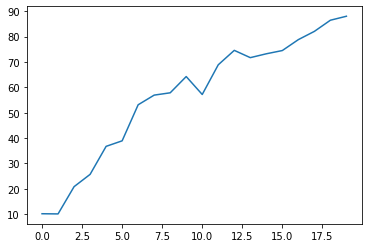

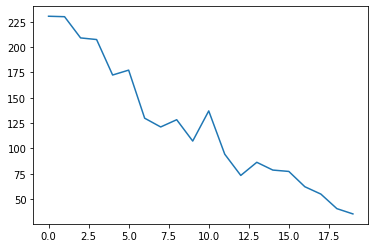

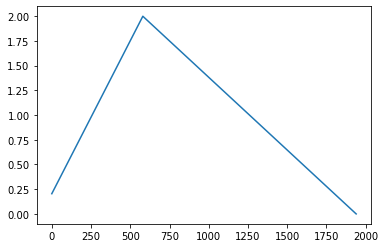

In [32]:
args.batch_size = 512
train_loader, test_loader = get_data(args)
net = ResNet([9, 9, 9])
net = net.to(device)
batch_size = args.batch_size
args.epochs = 20
args.lr = 2
args.sch = 'clr'
args.blr = 0.2
args.elr = 0.0001

optimizer = torch.optim.SGD(net.parameters(), 0.1, momentum=0.9, weight_decay=1e-4)

if args.sch == 'constant':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80, 90], gamma=0.1)
else:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=len(train_loader), epochs=args.epochs,
                                                    anneal_strategy='linear', div_factor=int(args.lr / args.blr),
                                                    final_div_factor=int(args.lr / args.elr))
num_epochs = args.epochs

criterion = nn.CrossEntropyLoss()
print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(args.lr))
print('| Optimizer = ' + optimizer.__class__.__name__)


elapsed_time = 0
new_lr = args.lr
acc_list = []
loss_list = []
lr_list = []
for epoch in range(num_epochs):
    start_time = time.time()
    train(epoch)
    if args.sch == 'constant': scheduler.step()
    acc, loss = test(epoch)
    acc_list.append(acc)
    loss_list.append(loss)
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' % get_hms(elapsed_time))

print('\n[Phase 4] : Testing model')

plt.plot(np.arange(num_epochs), acc_list, label='Accuracy')
plt.show()
plt.close()
plt.plot(np.arange(num_epochs), loss_list, label='Loss')
plt.show()
plt.close()

plt.plot(np.arange(len(lr_list)), lr_list, label='Learning rate')
plt.show()
plt.close()

### 0.1 - 1

Files already downloaded and verified
Files already downloaded and verified

[Phase 3] : Training model
| Training Epochs = 20
| Initial Learning Rate = 1
| Optimizer = SGD

=> Training Epoch #0
| Epoch [  0/ 20] Iter[  1/ 98]		Loss: 2.7644 Acc@1: 12.695%

| Validation Epoch #0			Loss: 1.9860 Acc@1: 28.47%
| Elapsed time : 0:00:32

=> Training Epoch #1
| Epoch [  1/ 20] Iter[  1/ 98]		Loss: 1.8834 Acc@1: 30.664%

| Validation Epoch #1			Loss: 1.7928 Acc@1: 36.48%
| Elapsed time : 0:01:05

=> Training Epoch #2
| Epoch [  2/ 20] Iter[  1/ 98]		Loss: 1.7146 Acc@1: 34.375%

| Validation Epoch #2			Loss: 1.6355 Acc@1: 45.73%
| Elapsed time : 0:01:35

=> Training Epoch #3
| Epoch [  3/ 20] Iter[  1/ 98]		Loss: 1.5068 Acc@1: 45.898%

| Validation Epoch #3			Loss: 1.3288 Acc@1: 50.68%
| Elapsed time : 0:02:06

=> Training Epoch #4
| Epoch [  4/ 20] Iter[  1/ 98]		Loss: 1.2612 Acc@1: 53.906%

| Validation Epoch #4			Loss: 1.3457 Acc@1: 57.57%
| Elapsed time : 0:02:37

=> Training Epoch #5
| Epo

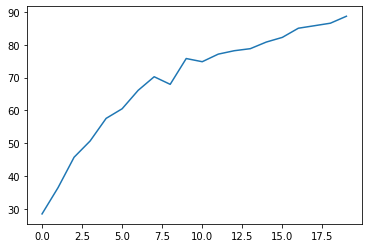

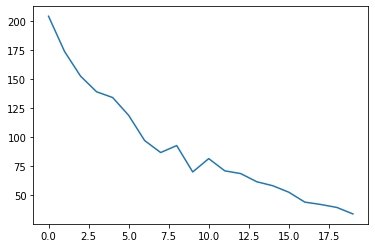

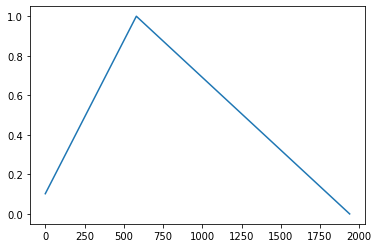

In [33]:
args.batch_size = 512
train_loader, test_loader = get_data(args)
net = ResNet([9, 9, 9])
net = net.to(device)
batch_size = args.batch_size
args.epochs = 20
args.lr = 1
args.sch = 'clr'
args.blr = 0.1
args.elr = 0.0001

optimizer = torch.optim.SGD(net.parameters(), 0.1, momentum=0.9, weight_decay=1e-4)

if args.sch == 'constant':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 80, 90], gamma=0.1)
else:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=len(train_loader), epochs=args.epochs,
                                                    anneal_strategy='linear', div_factor=int(args.lr / args.blr),
                                                    final_div_factor=int(args.lr / args.elr))
num_epochs = args.epochs

criterion = nn.CrossEntropyLoss()
print('\n[Phase 3] : Training model')
print('| Training Epochs = ' + str(num_epochs))
print('| Initial Learning Rate = ' + str(args.lr))
print('| Optimizer = ' + optimizer.__class__.__name__)


elapsed_time = 0
new_lr = args.lr
acc_list = []
loss_list = []
lr_list = []
for epoch in range(num_epochs):
    start_time = time.time()
    train(epoch)
    if args.sch == 'constant': scheduler.step()
    acc, loss = test(epoch)
    acc_list.append(acc)
    loss_list.append(loss)
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' % get_hms(elapsed_time))

print('\n[Phase 4] : Testing model')

plt.plot(np.arange(num_epochs), acc_list, label='Accuracy')
plt.show()
plt.close()
plt.plot(np.arange(num_epochs), loss_list, label='Loss')
plt.show()
plt.close()

plt.plot(np.arange(len(lr_list)), lr_list, label='Learning rate')
plt.show()
plt.close()